In [1]:
import h5py
import numpy as np
import os

In [2]:
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.utils.astro as astro_utils

# Find IDs

## Load Galaxy Data

In [3]:
snum = 600
sim_data_dir = '/scratch/projects/xsede/GalaxiesOnFIRE/mhdcv/m12i_res7100_mhdcv_old/output'
data_dir = '/scratch/03057/zhafen/linefinder_data/multiphysics/m12i_res7100_mhdcv/data'
halo_data_dir = '/scratch/03057/zhafen/halo_files/multiphysics/m12i_res7100_mhdcv'

In [4]:
s_data = particle_data.ParticleData(
    sdir = sim_data_dir,
    halo_data_dir = halo_data_dir,
    snum = snum,
    ptype = 4,
    main_halo_id = 0,
)

In [5]:
s_plotter = generic_plotter.GenericPlotter( s_data )

## Select Particles in Galaxy

### Make sure it looks okay

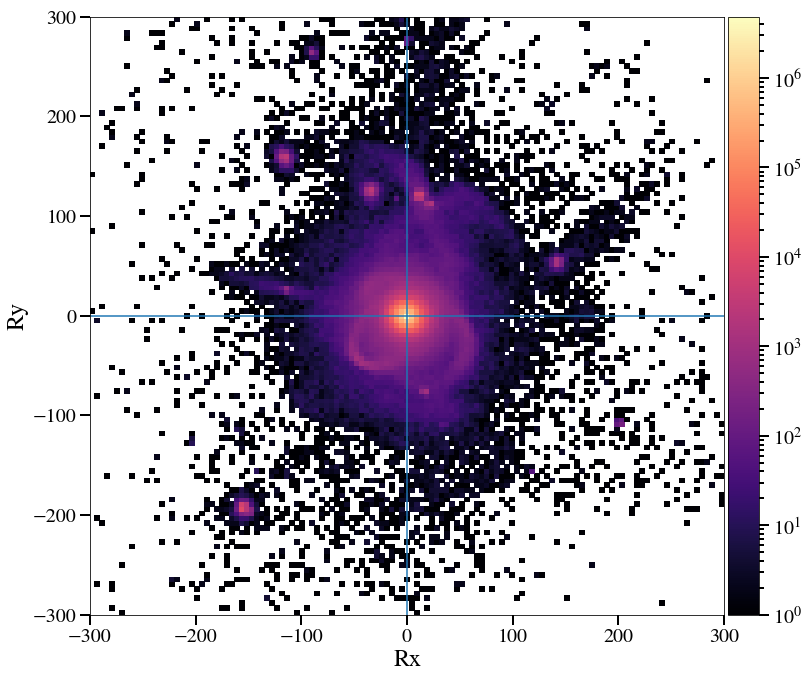

In [6]:
%matplotlib inline
fig = plt.figure( figsize=(12,11), facecolor='w' )
ax = plt.gca()

s_plotter.histogram2d(
    'Rx',
    'Ry',
    ax = ax,
    x_range = [ -300, 300 ],
    y_range = [ -300, 300 ],
)

ax.axvline()
ax.axhline()

### Calculate Age

In [7]:
formation_redshift = 1. / s_data.get_data( 'Age' ) - 1.

In [8]:
formation_age = astro_utils.age_of_universe(
    formation_redshift,
    h = s_data.data_attrs['hubble'],
    omega_matter = s_data.data_attrs['omega_matter']
)

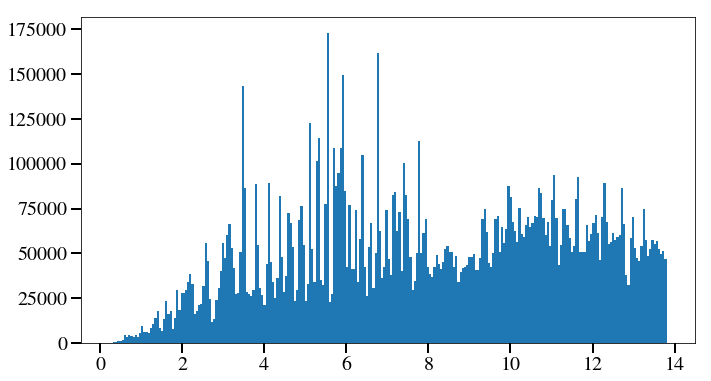

In [9]:
fig = plt.figure( figsize=(11, 6), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    formation_age,
    bins = 256,
)

### Sample IDs

In [10]:
ids = s_data.get_data( 'ID' )

In [11]:
n = 1e5
age_bins = np.linspace( formation_age.min(), formation_age.max(), 256 )

In [12]:
n_bins = age_bins.size - 1
n_per_bin = np.ceil( n / n_bins ).astype( int )

In [13]:
sampled_ids = []
for i in range( n_bins ):
    
    in_age_bin = ( age_bins[i] < formation_age ) & ( formation_age < age_bins[i+1] )
    n_in_bin = in_age_bin.sum()
    
    n_sampled = min( n_per_bin, n_in_bin )
    sampled_ids.append(
        np.random.choice( ids[in_age_bin], n_sampled, False )
    )
sampled_ids = np.concatenate( sampled_ids )

# Store ID Data

In [14]:
file_name = 'ids_full_m12imhdcv_galaxy.hdf5'
file_path = os.path.join( data_dir, file_name )
g = h5py.File( file_path, 'w' )

In [15]:
g.create_dataset( 'target_ids', data=sampled_ids )

<HDF5 dataset "target_ids": shape (99607,), type "<i8">

In [16]:
g.create_dataset( 'age_bins', data=age_bins )

<HDF5 dataset "age_bins": shape (256,), type "<f8">

In [17]:
g.close()